# Задача 18
## Распознавание британских гласных

Распознавание британских гласных (11 штук) по данным с динамиков, рекомендуется использовать нормированные признаки (файл .scaled). Решить задачу многоклассовой классификации с помощью решающего дерева. Реализовать метод решающего дерева, построить область разделения на классы в проекции на любые 2 признака.

# Д/З № 2

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read data
Данные https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html

In [2]:
data = pd.read_csv('../../data/vowel.scale', sep = ' ', header=None)

# clean data
for i in range(1,11):
    data[i] = data[i].apply(lambda x: x.split(':')[1]).astype('float64')
    
data.rename({0:'y'}, axis=1, inplace=True)

data.drop(11, axis=1, inplace=True)

In [3]:
data.sample()

,y,1,2,3,4,5,6,7,8,9,10
185,9,-0.613583,0.116887,0.194872,0.636111,-0.235472,-0.325956,0.433333,-0.207013,0.839151,0.350455


In [4]:
data, test = train_test_split(data, shuffle=True, stratify=data['y'], test_size=0.2,  random_state=11)

In [5]:
tr_col = list(range(1,11))
X = data[tr_col].values
y = data['y'].values

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model = DecisionTreeClassifier(random_state=4)
score = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

score.mean(), score.std()

(0.8285831285831285, 0.04203126246750487)

In [6]:
parameters={
    'min_samples_split' : range(2,20,2),
    'max_depth': range(1,20,2),
    'max_features': range(1,11)    
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model = DecisionTreeClassifier(random_state=4)

clf = GridSearchCV(model, parameters, scoring='accuracy', n_jobs=-1, cv=cv)
clf.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=4,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': range(2, 20, 2), 'max_depth': range(1, 20, 2), 'max_features': range(1, 11)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [7]:
best_model = clf.best_estimator_

score = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')

score.mean(), score.std()

(0.8345413595413594, 0.04087395162693838)

### Проверяем на отложенной выборке

In [8]:
pred = best_model.predict(test[tr_col])
accuracy_score(test['y'], pred)

0.8584905660377359

In [9]:
def plot_forest(X, y, model):
    colors = ['black', 'grey', 'brown', 'orange', 'olive', 'green',
         'cyan', 'blue', 'purple', 'red', 'white']
    
    plt.figure(figsize=(20,10))
    ax = plt.gca()
    h = 0.02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    model.fit(X, y)
    
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.4)
    ax.set_title("Разделяющая поверхность" , size=24)

    ax.scatter(X[:, 0], X[:, 1], c=np.array(colors)[y], s=60)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

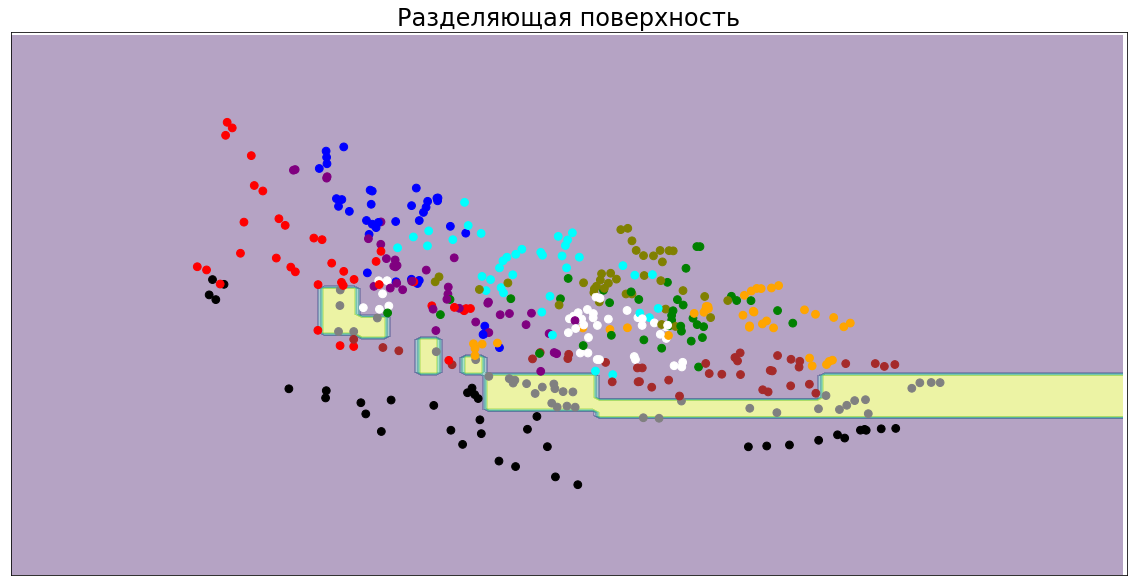

In [10]:
plot_forest(X[:,:2], y, model)

# Д/З № 3

### Построить график зависимости ошибки и стандартного отклонения от объема выборки.

In [11]:
def mean_std(n):
    score = cross_val_score(best_model, X[:n], y[:n], scoring='accuracy', cv=2)
    return {'mean':score.mean(), 'std':score.std()}

In [12]:
mean = []
std = []
for n in range(40, len(X), 1):
    res = mean_std(n)
    mean.append(res['mean'])
    std.append(res['std'])

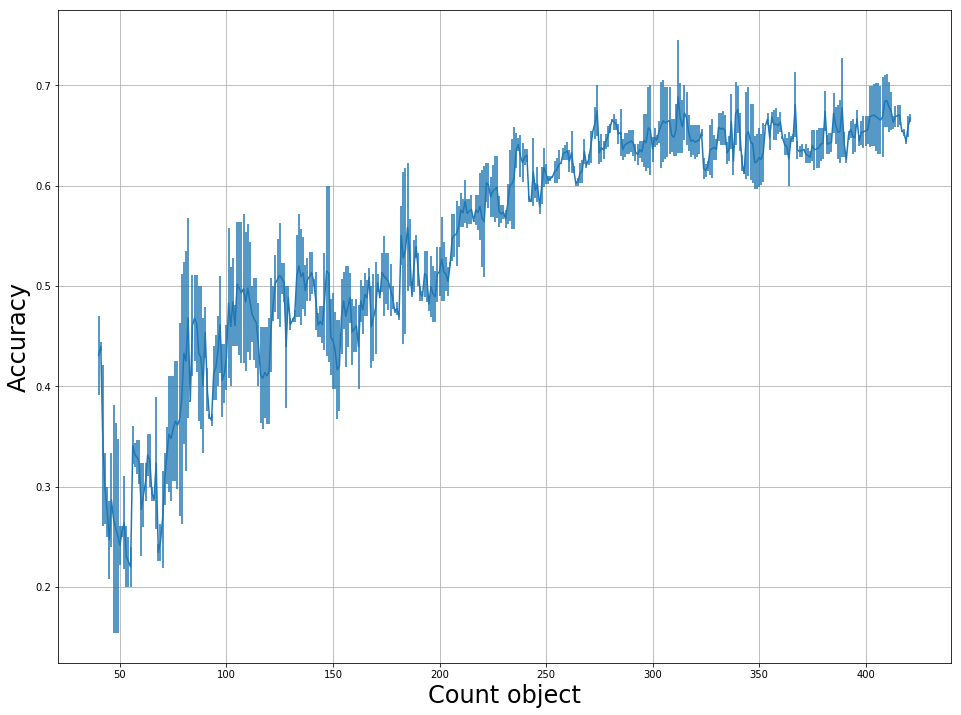

In [13]:
plt.figure(figsize=(16,12))
plt.grid(True)

plt.errorbar(range(40, len(X), 1),mean, yerr=std) 
plt.xlabel('Count object', size=24)
plt.ylabel('Accuracy', size=24)

plt.savefig(fname='std.png',format='png')
plt.show()